# Merging Parks Data

In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

----
&nbsp;
### Extracting the geometric elements from `nps_boundary.geojson`

In [55]:
df = pd.read_csv("DATA/parks.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (56, 6)


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [56]:
# url = https://catalog.data.gov/dataset/national-park-boundaries/resource/cee04cfe-f439-4a65-91c0-ca2199fa5f93

gdf = gpd.read_file('DATA/nps_boundary.geojson')
print(f"Shape: {gdf.shape}")

Shape: (510, 10)


In [57]:
# Subset on National Parks
gdf_nat_parks = gdf[gdf['UNIT_TYPE'] == 'National Park']
print(f"Shape: {gdf_nat_parks.shape}")
gdf_nat_parks.head()

Shape: (58, 10)


,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
2,None,ACAD,None,Acadia,National Park,None,None,None,Shift 0.03 mi.,"MULTIPOLYGON (((-68.22595 44.39584, -68.22766 ..."
29,None,BIBE,None,Big Bend,National Park,None,None,None,Shift 0.03 mi.,"POLYGON ((-102.84985 29.35623, -102.85101 29.3..."
35,None,BISC,None,Biscayne,National Park,None,None,None,Good,"POLYGON ((-80.34638 25.4484, -80.34631 25.4492..."
45,None,CANY,None,Canyonlands,National Park,None,None,None,Shifted 0.04 miles,"MULTIPOLYGON (((-109.88562 38.48543, -109.8853..."
49,None,CARE,None,Capitol Reef,National Park,None,None,None,Shifted 0.04 miles,"POLYGON ((-110.93617 37.7308, -110.93593 37.73..."


#### Shapes are different, there are park discrepancies

In [58]:
park_set_df = set(df["Park Code"])
park_set_gdf = set(gdf_nat_parks['UNIT_CODE'])

geo_diff = park_set_df.difference(park_set_gdf)
print(f"Not in GeoParks: {geo_diff}")

csv_diff = park_set_gdf.difference(park_set_df)
print(f"Not in Parks.csv: {csv_diff}")

Not in GeoParks: {'CONG', 'PINN', 'SEKI'}
Not in Parks.csv: {'VIIS', 'KICA', 'NPSA', 'SEQU', 'COSW'}


In [59]:
# Retrieve names of parks in CSV but not in geoJSON (geo_diff)
print("Park names from CSV missing in geoJSON:")
for park in geo_diff:
    park_names = df.loc[df['Park Code'] == park, 'Park Name']
    if not park_names.empty:
        print(f"{park}: {park_names.iloc[0]}")
    else:
        print(f"No matching park name found in CSV for park code: {park}")

Park names from CSV missing in geoJSON:
CONG: Congaree National Park
PINN: Pinnacles National Park
SEKI: Sequoia and Kings Canyon National Parks


In [60]:
# Create a DataFrame of the matching UNIT_CODEs in gdf_nat_parks for elements in park_set_df
matching_parks_gdf = gdf_nat_parks[gdf_nat_parks['UNIT_CODE'].isin(park_set_df)]

# Display the resulting DataFrame of matching parks
print(f"Shape: {matching_parks_gdf.shape}")
matching_parks_gdf.head()

Shape: (53, 10)


,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
2,None,ACAD,None,Acadia,National Park,None,None,None,Shift 0.03 mi.,"MULTIPOLYGON (((-68.22595 44.39584, -68.22766 ..."
29,None,BIBE,None,Big Bend,National Park,None,None,None,Shift 0.03 mi.,"POLYGON ((-102.84985 29.35623, -102.85101 29.3..."
35,None,BISC,None,Biscayne,National Park,None,None,None,Good,"POLYGON ((-80.34638 25.4484, -80.34631 25.4492..."
45,None,CANY,None,Canyonlands,National Park,None,None,None,Shifted 0.04 miles,"MULTIPOLYGON (((-109.88562 38.48543, -109.8853..."
49,None,CARE,None,Capitol Reef,National Park,None,None,None,Shifted 0.04 miles,"POLYGON ((-110.93617 37.7308, -110.93593 37.73..."


In [61]:
# Define the keywords to match in the UNIT_NAME column
keywords = ['Pinnacles', 'Sequoia', 'Congaree']
pattern = '|'.join(keywords)  # This creates a pattern like 'Pinnacles|Sequoia|Congaree'

# Filter the GeoDataFrame for rows where UNIT_NAME contains any of the keywords
# Using case=False for case-insensitivity and na=False to ignore NaN values
matching_gdf = gdf[gdf['UNIT_NAME'].str.contains(pattern, case=False, na=False)]
matching_gdf

,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
223,None,PINN,None,Pinnacles,National Monument,None,None,None,Shifted 0.06 miles,"MULTIPOLYGON (((-121.23966 36.54625, -121.2395..."
415,None,COSW,None,Congaree,National Park,None,None,2007-08-27,POC for this update: alex_gregg@nps.gov - htt...,"MULTIPOLYGON (((-80.64514 33.75282, -80.645 33..."
508,None,SEQU,None,Sequoia,National Park,None,None,2004-01-09,Lands,"POLYGON ((-118.70637 36.66475, -118.70636 36.6..."


#### Change the `UNIT_CODE` of Congaree and Sequoia to match the .csv and append to `matching_parks_gdf`

In [62]:
print(geo_diff)

{'CONG', 'PINN', 'SEKI'}


In [63]:
index_to_update = 415  
new_value = 'CONG'

if index_to_update in gdf.index:
    # Update the UNIT_CODE at the specific index
    matching_gdf.loc[index_to_update, 'UNIT_CODE'] = new_value
else:
    print(f"Index {index_to_update} does not exist in the DataFrame.")

In [64]:
index_to_update = 508  
new_value = 'SEKI'

if index_to_update in gdf.index:
    # Update the UNIT_CODE at the specific index
    matching_gdf.loc[index_to_update, 'UNIT_CODE'] = new_value
else:
    print(f"Index {index_to_update} does not exist in the DataFrame.")

In [65]:
geo_df = pd.concat([matching_parks_gdf, matching_gdf])
assert geo_df.shape[0] == 56, "The DataFrame has incorrect dimension"

In [66]:
park_set_df = set(df["Park Code"])
park_set_gdf = set(geo_df['UNIT_CODE'])
geo_diff = park_set_df.difference(park_set_gdf)

assert geo_diff == set(), "The difference is not an empty set as required"

In [67]:
geo_df = geo_df[['UNIT_CODE', 'geometry']]
assert geo_df.shape == (56, 2), "The DataFrame has incorrect dimensions"

----
&nbsp;
### Cleaning `parks.csv` and merging with geometry data 
on 'Park Code' == 'UNIT_CODE'


In [68]:
print(f"Shape: {df.shape}")
df.head()

Shape: (56, 6)


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [69]:
# convert column to lowercase, replace spaces
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

In [70]:
# convert acres to hectares
def acres_to_hectares(acres):
    return round(acres * 0.404686, 2)

df['hectares'] = df['acres'].apply(acres_to_hectares)

In [72]:
# Remove all text beyond " National Park" including variations like " and Preserve"
df['park_name'] = df['park_name'].str.replace(r' National Park.*', '', case=False, regex=True)

In [74]:
merged_parks = pd.merge(df, geo_df, left_on='park_code', right_on='UNIT_CODE')
merged_parks = merged_parks.drop(columns=['acres', 'latitude', 'longitude', 'UNIT_CODE'])

# Ensure the merged DataFrame is a GeoDataFrame with the correct geometry column
merged_geo_parks = gpd.GeoDataFrame(merged_parks, geometry=merged_parks['geometry'])

In [75]:
print(f"Type: {type(merged_geo_parks)}\nShape: {merged_geo_parks.shape}")
merged_geo_parks.head()

Type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (56, 5)


,park_code,park_name,state,hectares,geometry
0,ACAD,Acadia,ME,19178.07,"MULTIPOLYGON (((-68.22595 44.39584, -68.22766 ..."
1,ARCH,Arches,UT,30966.17,"POLYGON ((-109.56204 38.60475, -109.56264 38.6..."
2,BADL,Badlands,SD,98239.95,"MULTIPOLYGON (((-102.27705 43.5449, -102.27707..."
3,BIBE,Big Bend,TX,324219.45,"POLYGON ((-102.84985 29.35623, -102.85101 29.3..."
4,BISC,Biscayne,FL,69979.92,"POLYGON ((-80.34638 25.4484, -80.34631 25.4492..."


In [76]:
# Assert that there are no NaN values in merged_parks
assert not merged_geo_parks.isna().any().any(), "There are NaN values in merged_parks DataFrame"

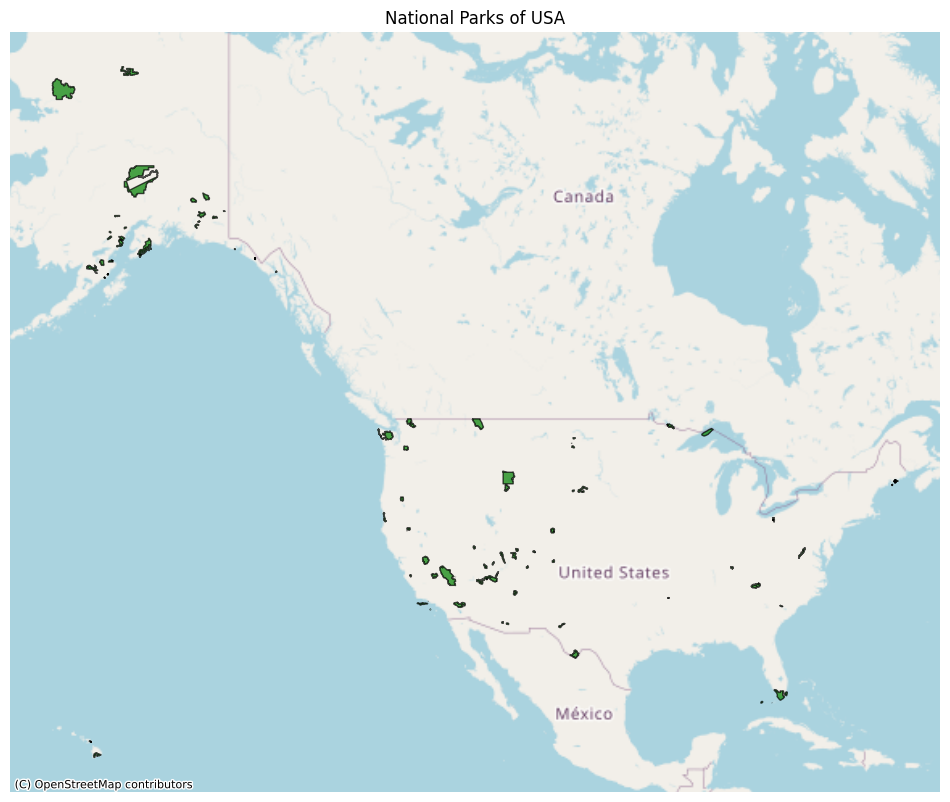

In [77]:
# Check and set CRS to EPSG:4326 if necessary (WGS 84 - latitude/longitude)
if merged_geo_parks.crs is None or merged_geo_parks.crs.to_string() != 'EPSG:4326':
    merged_geo_parks = merged_geo_parks.to_crs(epsg=4326)

# Convert to Web Mercator (EPSG:3857) for basemap compatibility
merged_geo_parks = merged_geo_parks.to_crs(epsg=3857)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 10))
merged_geo_parks.plot(ax=ax, color='green', edgecolor='black', alpha=0.7)

# Add a basemap, from OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and axis off for better visualization
ax.set_title('National Parks of USA')
ax.set_axis_off()

# Show the plot
plt.savefig("Images/USParks.png")
plt.show()

In [78]:
# Export GeoDataFrame
merged_geo_parks.to_file("DATA/parks.geojson", driver="GeoJSON")